In [ ]:
!pip install qiskit
!pip install pylatexenc
!pip install qiskit-ibm-provider

In [2]:
import numpy as np
from qiskit import QuantumCircuit

from qiskit import transpile

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14, 'font.family': 'serif', 'mathtext.fontset': 'dejavuserif'})
import random
import math
from qiskit.visualization import plot_histogram
import pandas as pd
import seaborn as sns
from qiskit_ibm_provider import IBMProvider

In [3]:
def normalized_absolute_probabilistic_distance(dict1, dict2):
    # Check if dictionaries have the same keys
    if set(dict1.keys()) != set(dict2.keys()):
        raise ValueError("Response must have the same lenght")
    # Compute the sum of the absolute differences between the corresponding values
    sum_diff = sum(abs((dict1[key] - dict2[key])) for key in dict1.keys())
    distance = sum_diff / 2 # Because the sum has range [0,2], then /2 to normalize to range [0,1]
    return distance

In [ ]:
provider = IBMProvider(token='YOUR_TOKEN')
# display current supported backends
print(provider.backends())

Uniqueness: for each pair of devices and for each challenge, calculate the normalized distance.

In [ ]:
# get IBM's simulator backend
backend_array=[]
backend_array.append(provider.get_backend('ibm_kyoto'))
backend_array.append(provider.get_backend('ibm_osaka'))
backend_array.append(provider.get_backend('ibm_brisbane'))

In [5]:
n_challenge = 10
n_qubits = 8
shots=20000
n_runs = 5

def generate_random_array():
  x_challenge = []
  for i in range(n_challenge):
    tuple_values = tuple(random.uniform(0, 2*math.pi) for _ in range(n_qubits))
    x_challenge.append(tuple_values)
  return x_challenge

a_challenge=generate_random_array()
b_challenge=generate_random_array()
c_challenge=generate_random_array()
d_challenge=generate_random_array()
e_challenge=generate_random_array()
f_challenge=generate_random_array()

In [6]:
import json

def qcirc(i):
  # Create a Quantum Circuit
  circuit = QuantumCircuit(n_qubits, n_qubits)
  # Compute average response
  for j in range(n_qubits):
    if j%2==0:
      circuit.rz(a_challenge[i][j],j)
      circuit.ry(b_challenge[i][j],j)
      circuit.rx(c_challenge[i][j],j)
    else:
      circuit.rz(d_challenge[i][j],j)
      circuit.ry(e_challenge[i][j],j)
      circuit.rx(f_challenge[i][j],j)
      circuit.cz(j,j-1)

  for j in range(1,n_qubits-1):
    if j%2==1:
      circuit.rz(a_challenge[i][j],j)
      circuit.ry(b_challenge[i][j],j)
      circuit.rx(c_challenge[i][j],j)
    else:
      circuit.rz(d_challenge[i][j],j)
      circuit.ry(e_challenge[i][j],j)
      circuit.rx(f_challenge[i][j],j)
      circuit.cz(j,j-1)

  circuit.barrier()
  circuit.measure(range(n_qubits), range(n_qubits))
  #drawing the circuit
  #circuit.draw('mpl')
  return circuit
def qpuf_ibm(qc,backend):
  qc_compiled = transpile(qc, backend)
  job = backend.run(qc_compiled, shots=shots)
  # list of dictionaries, one for each challenge
  result = job.result().get_counts()
  # list of formatted responses
  responses=[]
  for j in range(len(result)):
    response = {}
    for i in range(2**n_qubits):
      binary_string = format(i, '0' + str(n_qubits) + 'b')
      # If it finds the combination copy the value and divide it by the number of shots to normalize it between 0 and 1, otherwise put 0
      response[binary_string] = result[j].get(binary_string,0)/shots
    responses.append(response)
  return responses

def uniqueness():
  unique_table = pd.DataFrame(columns=["i-th device","j-th device","n-th challenge", "dist"])
  responses=[]
  for i in range(3):
    file_path = f'./results/backend{i}_table.json'
    with open(file_path, 'r') as json_file:
      r=json.load(json_file)
    responses.append(r)

  for i in range(3):
    for j in range(i + 1, 3):
      for n in range(n_challenge):
        distance = normalized_fractional_hamming_intradistance(responses[i][n], responses[j][n])
        unique_table.loc[len(unique_table)] = [i,j,n, distance]
  unique_table['i-th device']=unique_table['i-th device'].astype(int)
  unique_table['j-th device']=unique_table['j-th device'].astype(int)
  unique_table['n-th challenge']=unique_table['n-th challenge'].astype(int)
  return unique_table

unique_table=uniqueness()
file_path = "./results/unique_table.csv"
unique_table.to_csv(file_path, index=False)
print("Dati salvati correttamente in:", file_path)
unique_table

Dati salvati correttamente in: ./results/unique_table.csv


,i-th device,j-th device,n-th challenge,dist
0,0,1,0,0.38465
1,0,1,1,0.34060
2,0,1,2,0.15240
3,0,1,3,0.40150
4,0,1,4,0.40215
5,0,1,5,0.34160
6,0,1,6,0.27720
7,0,1,7,0.40225
8,0,1,8,0.20775
9,0,1,9,0.20345


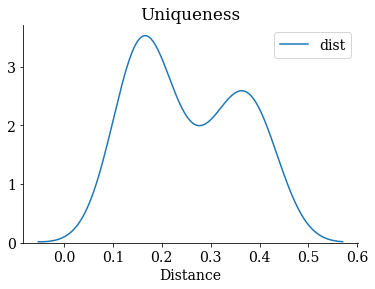

In [11]:
# Plot KDE plot
sns.kdeplot(unique_table['dist'])
# Set plot title
plt.title('Uniqueness')
# Hide top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Distance')

plt.savefig('./results/uniqueness.png')
# Show plot
plt.show()